First we are going to load the data.

In [1]:
import csv
import pandas as pd

In [2]:
data = pd.read_csv("./../data/in_silico_growth_curve.csv")

Let's see what the datafile contents are.

In [3]:
data

,times,cells
0,0.000000,8677.144668
1,1.500000,26920.855990
2,3.000000,63176.862474
3,4.500000,249712.054657
4,6.000000,442178.369581
5,7.500001,802923.563655
6,9.000001,875907.621559
7,10.500001,856617.310790
8,12.000001,885705.601724
9,13.500001,912408.715922


It's a very small dataset with just 10 time points showing the number of cells over time. With these short time series, both having a mechanistic model to fit it and having a Bayesian framework to do so helps us to make better sense of the science behind the process. We can visualize the data as.

Text(0, 0.5, 'cells')

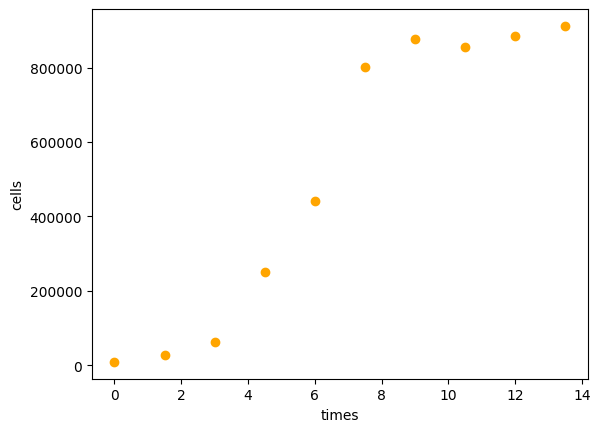

In [4]:
import matplotlib.pyplot as plt
plt.plot(data['times'],data['cells'],'o',color ='orange')
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])


However that can be complicated, let's start with the most simple way of fitting a nonlinear ODE model to the data.

### Use of Biological Mechanistic knowledge.
This data is a growth data of the cells where they consume nutrients and we can use the blahblah model

$$
\frac{dN}{dt} = -Q_n \frac{\mu_{max}N}{N+K_s}(P\times10^6)
$$

$$
\frac{dP}{dt} = \frac{\mu_{max}N}{N+K_s} P
$$

### In this dataset the variable 'N' (nutrients) is latent (unobserved)

In [67]:
import numpy as np
from scipy.integrate import odeint
t = np.linspace(0, 15, 100)

def cells_grow(y,t,mu_max,Ks,Qn):
    N, P = y
    dydt = [0,0]
    dydt[0] = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dydt[1] = P*(mu_max*N)/(N+Ks)

    return dydt

def solved(y0,t,mu_max,Ks,Qn):
    sol = odeint(cells_grow, y0, t, args=(mu_max,Ks,Qn),rtol=1e-6,atol=1e-6)
    return sol

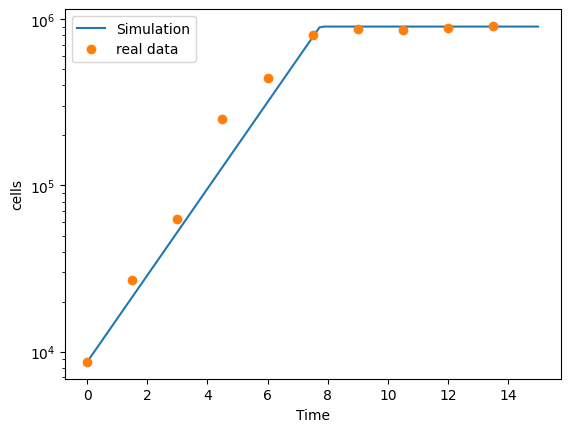

In [68]:
mu_max = 0.6
Ks = 0.09
Qn = 6.7e-10

y0 = [ 6e2, data['cells'][0] ]
num_cells_solved = solved(y0,t,mu_max,Ks,Qn)

plt.plot(t,num_cells_solved[:,1])
plt.plot(data['times'],data['cells'],'o')
plt.yscale('log')
plt.legend(['Simulation','real data'])
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()


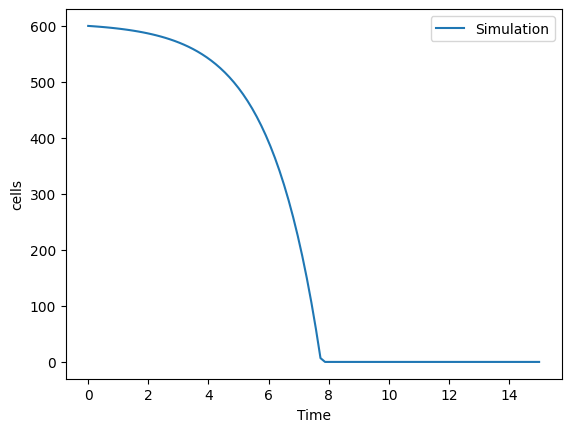

In [69]:
nutrients = solved(y0,t,mu_max,Ks,Qn)[:,0]

plt.plot(t,nutrients)
plt.legend(['Simulation','real data'])
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()

### Using pymc

In [7]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [8]:

from numba import njit

In [19]:
@njit
def cells_grow_pymc(y,t,theta):
    # unpack parameters
    N, P = y
    mu_max,Ks,Qn,N0 = theta
    
    dp_dt = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dq_dt = P*(mu_max*N)/(N+Ks)

    return [dp_dt, dq_dt]



In [20]:
# decorator with input and output types a Pytensor double float tensors
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func = cells_grow_pymc,  y0=[theta[-2:], data['cells'][0] ], t=data['times'], args=(theta,))

### Sampling 3 parameters and 2 initial conditions

In [50]:
import pymc as pm
import numpy as np
from scipy.integrate import odeint
from numba import njit
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

# Define the ODE system
@njit
def cells_grow_pymc(y, t, theta):
    # unpack parameters
    N, P = y
    mu_max, Ks, Qn = theta

    dp_dt = -Qn * (mu_max * N) / (N + Ks) * (P * 1e6)
    dq_dt = P * (mu_max * N) / (N + Ks)

    return [dp_dt, dq_dt]

# Pytensor decorator
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    y0 = [theta[-2], theta[-1]]
    result = odeint(cells_grow_pymc, y0, data['times'], args=(theta[:-2],),rtol=1e-6, atol=1e-6)
    return result

# Define the model
with pm.Model() as model:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.081, lower=0.05, upper=0.13)
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(6e2), sigma=1.0)
    P0 = pm.Lognormal('P0', mu=np.log(8677), sigma=0.1)
    
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max, Ks, Qn, N0, P0])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:, 1]), sigma=sigma, observed=np.log(data['cells'].values))

    # Sampling
    #trace = pm.sample(2000, tune=1000, step=pm.Slice(), return_inferencedata=True)



sampler = "NUTS PyMC ODE"
with model:
    trace_pymc_ode = pm.sample(tune=5000, draws=2000,step=pm.DEMetropolisZ())

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [mu_max, Ks, Qn, N0, P0, sigma]


Output()

Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.094,0.022,0.058,0.130,0.001,0.001,375.0,460.0,1.01
N0,752.316,626.714,79.401,1900.433,37.702,26.687,276.0,411.0,1.02
Qn,0.000,0.000,0.000,0.000,0.000,0.000,276.0,408.0,1.01
mu_max,0.680,0.020,0.643,0.716,0.001,0.001,402.0,434.0,1.01
sigma,0.157,0.050,0.083,0.247,0.003,0.002,339.0,519.0,1.01


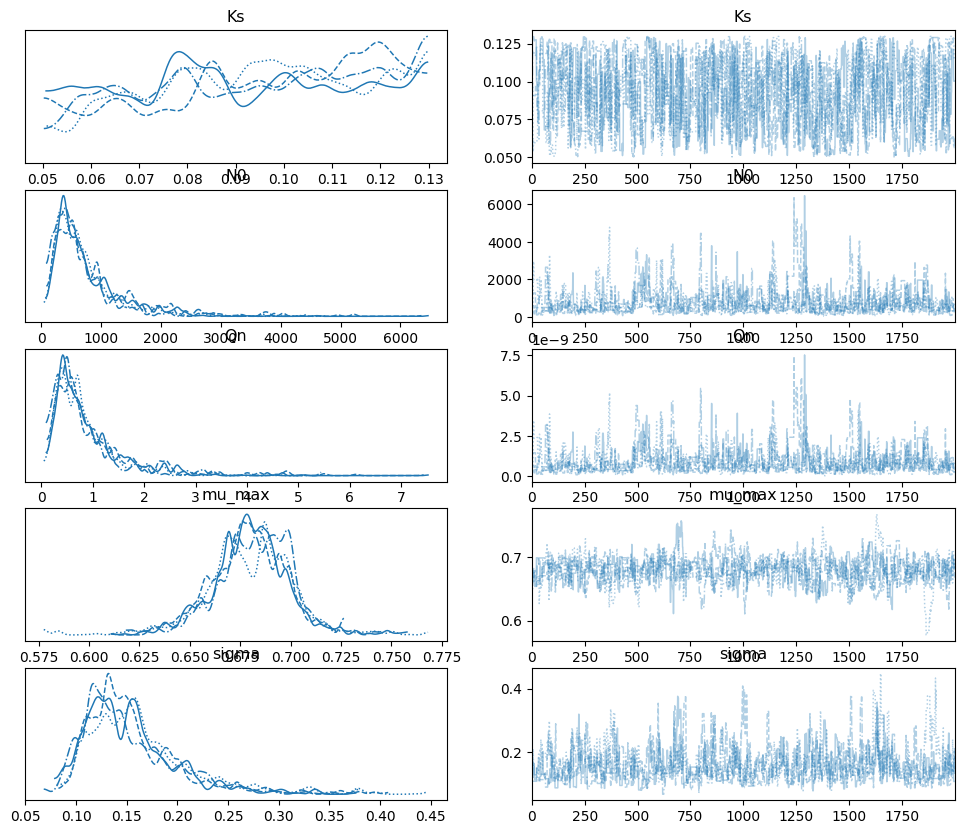

In [51]:
# Summarize results
import arviz as az
az.plot_trace(trace)
az.summary(trace)

In [27]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["mu_max", "Ks", "Qn"]
    row = trace_df.iloc[row_idx, :][cols].values

    time = data['times']
    theta = row
    x_y = odeint(func= cells_grow_pymc, y0 = [ 6e2, data['cells'][0] ], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [28]:
def plot_inference(
    ax,
    trace,
    num_samples=200,
    title="Cell growth Bayesian fit",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [35]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="cells growth"):
    ax.plot(data['times'], data['cells'], color="k", lw=lw, marker="o", markersize=12, label="data")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Cells", fontsize=14)
    ax.set_title(title, fontsize=16)
    return ax

In [36]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=data['times'],
    alpha=1,
    lw=3,
    title="bayesian",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Bayesian")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    ax.set_yscale('log')
    return ax

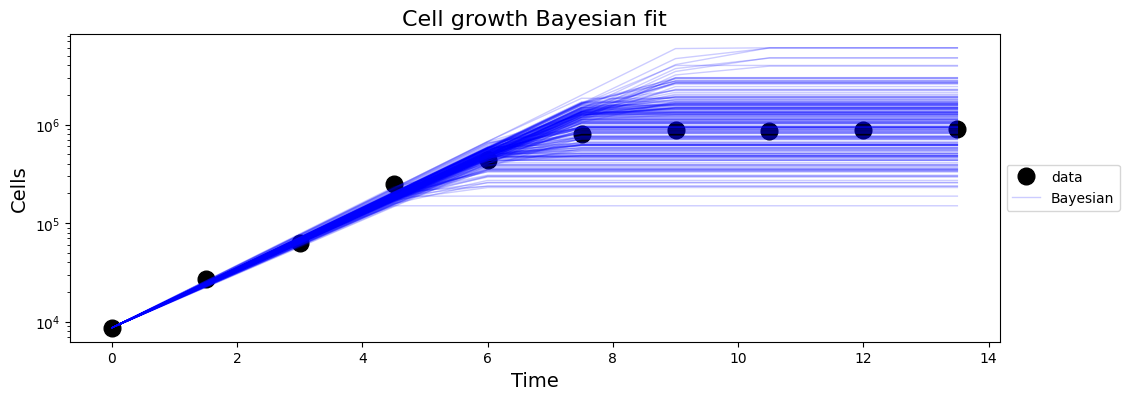

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace,num_samples=200);

### Sampling 3 parameters and only initial condition for nutrients

In [57]:


# Fixed value for P0
P0_value = 8677

# Define the model
with pm.Model() as model2:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.081, lower=0.05, upper=0.13)
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(6e2), sigma=1.0)
    
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max, Ks, Qn, N0, P0_value])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:, 1]), sigma=sigma, observed=np.log(data['cells'].values))

    # Sampling with NUTS for all parameters
    step = pm.DEMetropolisZ()
    trace = pm.sample(tune=5000, draws=2000, step=step, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [mu_max, Ks, Qn, N0, sigma]


Output()

Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


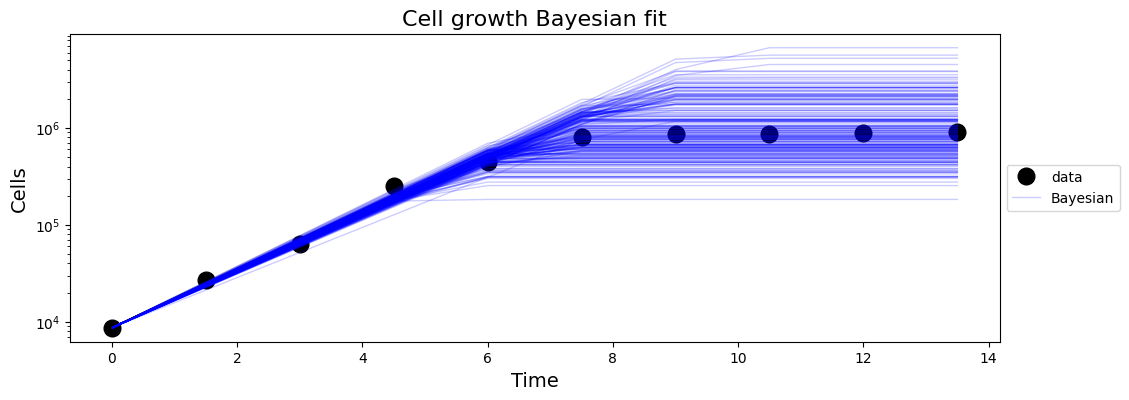

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace,num_samples=200);

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.090,0.023,0.053,0.127,0.001,0.001,427.0,533.0,1.01
N0,737.244,546.597,65.863,1710.253,25.805,18.259,386.0,805.0,1.02
Qn,0.000,0.000,0.000,0.000,0.000,0.000,370.0,812.0,1.02
mu_max,0.678,0.019,0.644,0.714,0.001,0.001,399.0,457.0,1.01
sigma,0.155,0.049,0.083,0.238,0.003,0.002,335.0,534.0,1.01


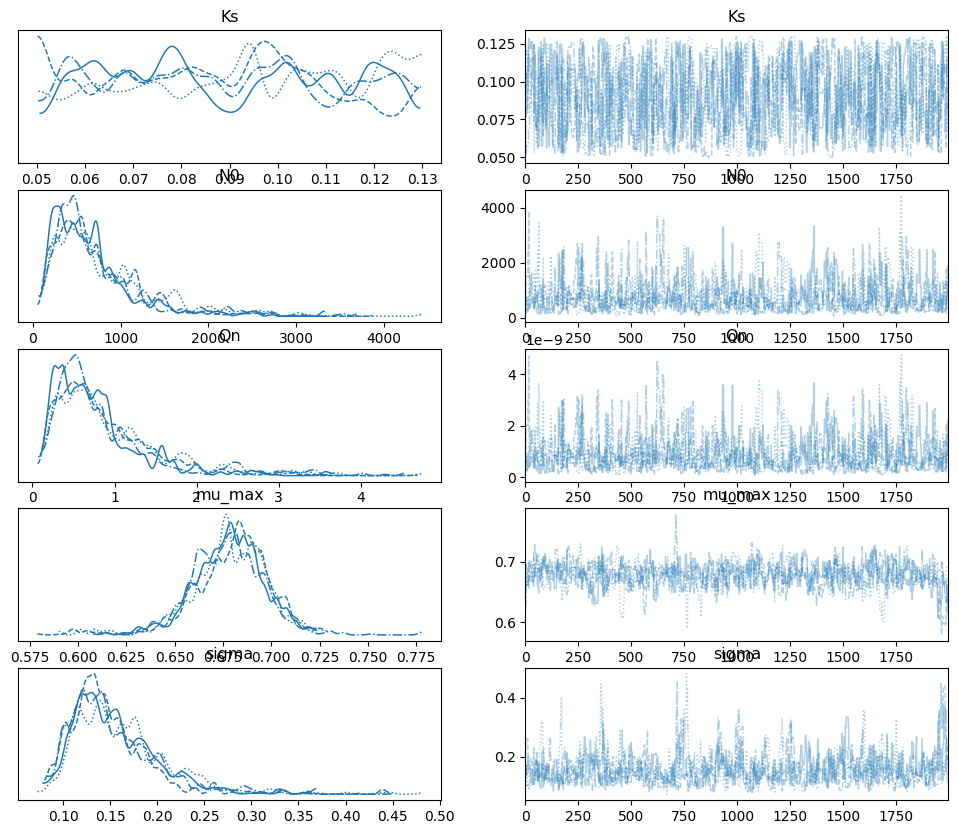

In [59]:
az.plot_trace(trace)
az.summary(trace)

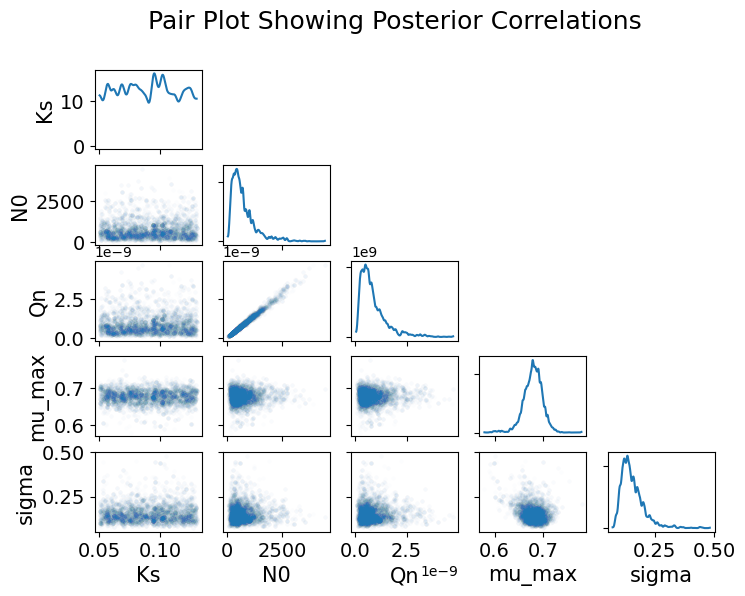

In [60]:
az.plot_pair(trace, figsize=(8, 6), scatter_kwargs=dict(alpha=0.01), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);